In [1]:
import pandas as pd
import time
import numpy as np
from sklearn.model_selection import train_test_split,cross_val_score, GridSearchCV
from sklearn.cross_validation import StratifiedKFold, KFold
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import random
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
import gc
from scipy.stats import skew, boxcox
from bayes_opt import BayesianOptimization
from scipy import sparse
from sklearn.metrics import log_loss
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

seed = 2017

D:\python\Anaconda2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Load Data

In [2]:
data_path = "../input/"
train_file = data_path + "train.json"
test_file = data_path + "test.json"
train_df = pd.read_json(train_file).reset_index()
test_df = pd.read_json(test_file).reset_index()
ntrain = train_df.shape[0]
print train_df.shape
print test_df.shape
print ntrain

(49352, 16)
(74659, 15)
49352


In [3]:
# sc_price
tmp = pd.concat([train_df['price'],test_df['price']])
ulimit = np.percentile(tmp.values, 99)
llimit = np.percentile(tmp.values, 1)

train_df.loc[:,'sc_price'] = train_df['price'].values.reshape(-1, 1)
test_df.loc[:,'sc_price'] = test_df['price'].values.reshape(-1, 1)

train_df.loc[train_df['sc_price']>ulimit, ['sc_price']] = ulimit
test_df.loc[test_df['sc_price']>ulimit, ['sc_price']] = ulimit
train_df.loc[train_df['sc_price']<llimit, ['sc_price']] = llimit
test_df.loc[test_df['sc_price']<llimit, ['sc_price']] = llimit



# sc_ba_price
inx_train = train_df['bathrooms'] == 0
inx_test = test_df['bathrooms'] == 0

non0_inx_train = ~inx_train
non0_inx_test = ~inx_test

train_df.loc[non0_inx_train,'sc_ba_price'] = train_df.loc[non0_inx_train,'sc_price']\
                                                /train_df.loc[non0_inx_train,'bathrooms']
test_df.loc[non0_inx_test,'sc_ba_price'] = test_df.loc[non0_inx_test,'sc_price']\
                                                /test_df.loc[non0_inx_test,'bathrooms']

train_df.loc[inx_train,'sc_ba_price'] = 0
test_df.loc[inx_test,'sc_ba_price'] = 0

train_df.loc[non0_inx_train,'bathrooms0'] = 1
test_df.loc[non0_inx_test,'bathrooms0'] = 1

train_df.loc[inx_train,'bathrooms0'] = 0
test_df.loc[inx_test,'bathrooms0'] = 0

# price per bedrooms

inx_train = train_df['bedrooms'] == 0
inx_test = test_df['bedrooms'] == 0

non0_inx_train = ~inx_train
non0_inx_test = ~inx_test

train_df.loc[non0_inx_train,'sc_be_price'] = train_df.loc[non0_inx_train,'sc_price'] \
                                                /train_df.loc[non0_inx_train,'bedrooms']
test_df.loc[non0_inx_test,'sc_be_price'] = test_df.loc[non0_inx_test,'sc_price']\
                                                /test_df.loc[non0_inx_test,'bedrooms']

train_df.loc[inx_train,'sc_be_price'] = 0
test_df.loc[inx_test,'sc_be_price'] = 0

train_df.loc[non0_inx_train,'bedrooms0'] = 1
test_df.loc[non0_inx_test,'bedrooms0'] = 1

train_df.loc[inx_train,'bedrooms0'] = 0
test_df.loc[inx_test,'bedrooms0'] = 0
# bathrooms

ulimit = 5

train_df['sc_bathrooms']=train_df['bathrooms']
test_df['sc_bathrooms']=test_df['bathrooms']

train_df.loc[train_df['sc_bathrooms']>ulimit,['sc_bathrooms']] = ulimit
test_df.loc[test_df['sc_bathrooms']>ulimit,['sc_bathrooms']] = ulimit

# bedrooms

ulimit = 8

train_df['sc_bedrooms']=train_df['bedrooms']
test_df['sc_bedrooms']=test_df['bedrooms']

train_df.loc[train_df['sc_bedrooms']>ulimit, ['sc_bedrooms']] = ulimit
test_df.loc[test_df['sc_bedrooms']>ulimit,['sc_bedrooms']] = ulimit

# longitude

tmp = pd.concat([train_df['longitude'],test_df['longitude']])
llimit = np.percentile(tmp.values, 0.1)
ulimit = np.percentile(tmp.values, 99.9)

train_df['sc_longitude']=train_df['longitude']
test_df['sc_longitude']=test_df['longitude']

train_df.loc[train_df['sc_longitude']>ulimit, ['sc_longitude']] = ulimit
test_df.loc[test_df['sc_longitude']>ulimit, ['sc_longitude']] = ulimit
train_df.loc[train_df['sc_longitude']<llimit, ['sc_longitude']] = llimit
test_df.loc[test_df['sc_longitude']<llimit, ['sc_longitude']] = llimit

# latitude

tmp = pd.concat([train_df['latitude'],test_df['latitude']])
llimit = np.percentile(tmp.values, 0.1)
ulimit = np.percentile(tmp.values, 99.9)

train_df['sc_latitude']=train_df['latitude']
test_df['sc_latitude']=test_df['latitude']

train_df.loc[train_df['sc_latitude']>ulimit, ['sc_latitude']] = ulimit
test_df.loc[test_df['sc_latitude']>ulimit, ['sc_latitude']] = ulimit
train_df.loc[train_df['sc_latitude']<llimit, ['sc_latitude']] = llimit
test_df.loc[test_df['sc_latitude']<llimit, ['sc_latitude']] = llimit


features_to_use  = ["sc_bathrooms", "sc_bedrooms", "sc_latitude", "sc_longitude",
                    "sc_price", "sc_ba_price", "sc_be_price"]

In [4]:
# count of photos #
train_df["num_photos"] = train_df["photos"].apply(len)
test_df["num_photos"] = test_df["photos"].apply(len)

# count of "features" #
train_df["num_features"] = train_df["features"].apply(len)
test_df["num_features"] = test_df["features"].apply(len)

# count of words present in description column #
train_df["num_description_words"] = train_df["description"].apply(lambda x: len(x.split(" ")))
test_df["num_description_words"] = test_df["description"].apply(lambda x: len(x.split(" ")))

# convert the created column to datetime object so as to extract more features 
train_df["created"] = pd.to_datetime(train_df["created"])
test_df["created"] = pd.to_datetime(test_df["created"])

# Let us extract some features like year, month, day, hour from date columns #
train_df["created_year"] = train_df["created"].dt.year
test_df["created_year"] = test_df["created"].dt.year
train_df["created_month"] = train_df["created"].dt.month
test_df["created_month"] = test_df["created"].dt.month
train_df["created_day"] = train_df["created"].dt.day
test_df["created_day"] = test_df["created"].dt.day
train_df["created_hour"] = train_df["created"].dt.hour
test_df["created_hour"] = test_df["created"].dt.hour

# adding all these new features to use list #
features_to_use.extend(["num_photos", "num_features", "num_description_words", "created_month", 
                        "created_day", "created_hour"])


In [5]:
full_data=pd.concat([train_df,test_df])

# SSL = preprocessing.StandardScaler()
# for col in features_to_use:
#     full_data[col], lam = boxcox(full_data[col] - full_data[col].min() + 1)
#     full_data[col] = SSL.fit_transform(full_data[col].values.reshape(-1,1)) 
skewed_cols = full_data[features_to_use].apply(lambda x: skew(x.dropna()))

SSL = preprocessing.StandardScaler()
skewed_cols = skewed_cols[skewed_cols > 0.25].index.values
for skewed_col in skewed_cols:
    full_data[skewed_col], lam = boxcox(full_data[skewed_col] - full_data[skewed_col].min() + 1)
    print skewed_col, '\t', lam
for col in features_to_use:
    full_data[col] = SSL.fit_transform(full_data[col].values.reshape(-1,1))
    train_df[col] = full_data.iloc[:ntrain][col]
    test_df[col] = full_data.iloc[ntrain:][col]

    
del full_data

sc_bathrooms 	-0.974792935849
sc_bedrooms 	0.474243433469
sc_longitude 	-12.8479101685
sc_price 	0.34122013083
sc_ba_price 	0.668968094532
sc_be_price 	0.462918736223
num_photos 	0.475560723219
num_features 	0.359523382085
num_description_words 	0.543711145224
created_hour 	-0.389913999668


D:\python\Anaconda2\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


In [7]:
features_to_use.extend(["listing_id","bedrooms0",'bathrooms0'])
categorical = ["display_address", "manager_id", "building_id", "street_address","listing_id"]
SSL = preprocessing.StandardScaler()


full_data=pd.concat([train_df,test_df])

for col in categorical:
    lbl = preprocessing.LabelEncoder()
    full_data[col] = lbl.fit_transform(list(full_data[col].values))
    full_data[col], lam = boxcox(full_data[col] - full_data[col].min() + 1)
    full_data[col] = SSL.fit_transform(full_data[col].values.reshape(-1,1)) 
    train_df[col] = full_data.iloc[:ntrain][col]
    test_df[col] = full_data.iloc[ntrain:][col]
    features_to_use.append(col)

# for f in categorical:
#         if train_df[f].dtype=='object':
#             #print(f)
#             lbl = preprocessing.LabelEncoder()
#             lbl.fit(list(train_df[f].values) + list(test_df[f].values))
#             train_df[f] = lbl.transform(list(train_df[f].values))
#             test_df[f] = lbl.transform(list(test_df[f].values))
      
#             features_to_use.append(f)

In [8]:
            
# full_data=pd.concat([train_df,test_df])
# # categorical.append('listing_id')
# # SSL = preprocessing.StandardScaler()
# # for col in categorical:
# #     full_data[col], lam = boxcox(full_data[col] - full_data[col].min() + 1)
# #     full_data[col] = SSL.fit_transform(full_data[col].values.reshape(-1,1)) 
# #     train_df[col] = full_data.iloc[:ntrain][col]
# #     test_df[col] = full_data.iloc[ntrain：][col]



# OHE = preprocessing.OneHotEncoder(sparse=True)
# start=time.time()
# full_data_sparse=OHE.fit_transform(full_data[categorical])
# print 'One-hot-encoding finished in %f seconds' % (time.time()-start)
# print full_data_sparse.shape   

# del full_data

In [9]:
# full_data_sparse[ntrain:]

In [10]:
train_df['features'] = train_df["features"]\
                        .apply(lambda x: " ".join(["_".join(i.split(" ")) for i in x]))\
                        .apply(lambda x: x.lower())
test_df['features'] = test_df["features"]\
                        .apply(lambda x: " ".join(["_".join(i.split(" ")) for i in x]))\
                        .apply(lambda x: x.lower())

print(train_df["features"].head())
tfidf = CountVectorizer(stop_words='english', max_features=200)
tr_sparse = tfidf.fit_transform(train_df["features"])
te_sparse = tfidf.transform(test_df["features"])

sparse_features = tfidf.get_feature_names()

0                                                     
1    doorman elevator fitness_center cats_allowed d...
2    laundry_in_building dishwasher hardwood_floors...
3                               hardwood_floors no_fee
4                                              pre-war
Name: features, dtype: object


In [14]:
train_X = sparse.hstack([train_df[features_to_use], tr_sparse]).tocsr()
test_X = sparse.hstack([test_df[features_to_use], te_sparse]).tocsr()

target_num_map = {'high':0, 'medium':1, 'low':2}
weight_num_map = {'high':1, 'medium':1, 'low':1}
train_y = np.array(train_df['interest_level'].apply(lambda x: target_num_map[x]))
W_train = np.array(train_df['interest_level'].apply(lambda x: weight_num_map[x]))

all_features = features_to_use + sparse_features
print train_X.shape, test_X.shape

(49352, 224) (74659, 224)


In [11]:
# index_low = train[train['interest_level'] == 'low']
# index_medium = train[train['interest_level'] == 'medium']
# index_high = train[train['interest_level'] == 'high']

In [12]:
# index_tmp = (list(index_medium.index[:3839])
#                     +list(index_high.index)
#                     +list(index_low.index[:3839]))
# # index_tmp= index_tmp.iloc(np.random.permutation(len(index_tmp)))
# # index_tmp

# random.shuffle(index_tmp)

In [13]:
# train_X = train_X[index_tmp,:]
# train_X.shape

In [21]:
start = time.time()

logreg = LogisticRegression(multi_class = 'multinomial',
                            n_jobs = 1, max_iter=10000000,tol = 1e-7)
param_grid = [{'C':[0.01,0.1,1,10],
               'solver':['lbfgs'],#, 'lbfgs', 'liblinear', 'sag'  'newton-cg', 
#                'class_weight':['balanced', None]
               }]
               
clf = GridSearchCV(logreg, param_grid, 
                   scoring = 'neg_log_loss',cv = 5,
                   n_jobs = -1,verbose = 10)
clf.fit(train_X,train_y)

# cross_val_score(logreg,train_X,train_y,
#                scoring = 'neg_log_loss',
#                cv = 5, n_jobs = -1).mean()
# print 'Took', time.time() - start
print 'best score\t',clf.best_score_
print 'best params\t',clf.best_params_

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done   8 out of  20 | elapsed:   14.8s remaining:   22.3s
[Parallel(n_jobs=-1)]: Done  11 out of  20 | elapsed:   30.3s remaining:   24.8s
[Parallel(n_jobs=-1)]: Done  14 out of  20 | elapsed:   39.5s remaining:   16.9s
[Parallel(n_jobs=-1)]: Done  17 out of  20 | elapsed:  1.1min remaining:   11.7s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  1.3min finished


best score	-0.630694110334
best params	{'C': 0.1, 'solver': 'lbfgs'}


In [11]:
# without categorical C=1 'ovr' -0.64628702713367092
# with categorical C=1 'ovr' -0.636559852534
# with categorical C=0.3 'multinomial' 'sag' -0.632190866047
# with categorical OHO C= 'multinomial' 'sag' too much time

# with categorical best score	-0.634837170476
# best params	{'C': 1, 'solver': 'newton-cg'}

# with categorical 'multinomial'
# best score	-0.630694621925
# best params	{'C': 0.1, 'solver': 'newton-cg'}
# best score	-0.630694110334
# best params	{'C': 0.1, 'solver': 'lbfgs'}

In [38]:
# logreg.fit(train_X,train_y)
tmp = clf.predict_proba(test_X)
tmp = pd.DataFrame(tmp)
tmp.columns = ['high','medium','low']

In [47]:
# test_blend_x_gbm = tmp1.values
# test_blend_x_gbm

# Tune LightGBM

### num_leaves, default=127, type=int, alias=num_leaf

    number of leaves in one tree



In [48]:
params = {
    'objective': 'multiclass',
    'num_class': 3,
    'learning_rate': 0.1,
    'metric': 'multi_logloss',
}
# params['metrics'] = 'multi_logloss'

for x in [8,15,31,63,127,255]:
    params['num_leaves'] = x
    clf = lgb.cv(params, cv_dataset,
                num_boost_round = 100000, nfold =5,
#                 metrics = 'multi_logloss',
                early_stopping_rounds = 50)


    print x, ' \t', clf.values()[0][-1], len(clf.values()[0])

8  	0.553575161847 1213
15  	0.552250341503 725
31  	0.552726428184 337
63  	0.554048933244 164
127  	0.555666503054 111
255  	0.559468993011 80


In [49]:
params['num_leaves'] = 15

### min_child_samples : int, default= 100
    Minimum number of data need in a child(leaf)

In [50]:
for x in [10, 20, 30, 50, 70, 80,90,100,110,120,150,170,200,230,260]:
#     rgr = lgb.LGBMClassifier(learning_rate=0.1,                             
#                              n_estimators=100000,
#                              num_leaves=num_leaves,
#                              min_child_samples = x)

#     rgr.fit(X_train,y_train,
#             eval_set=[(X_val,y_val)],
#             eval_metric='multi_logloss',
#             early_stopping_rounds=50,
#             verbose = False)
    params['min_child_samples'] = x
    clf = lgb.cv(params, cv_dataset,
                num_boost_round = 100000, nfold =5,
#                 metrics = 'multi_logloss',
                early_stopping_rounds = 50)    

    print x, ' \t', clf.values()[0][-1], len(clf.values()[0])

10  	0.554113822397 675
20  	0.554113822397 675
30  	0.553227873486 591
50  	0.552712734654 665
70  	0.552539757989 586
80  	0.552722214662 629
90  	0.552966841255 613
100  	0.552250341503 725
110  	0.553045514728 692
120  	0.553015043433 616
150  	0.553441603 577
170  	0.552646081281 636
200  	0.553032807676 578
230  	0.553528665355 612
260  	0.554649077941 647


In [51]:
params['min_child_samples'] = 100

### colsample_bytree : float default 1
    Subsample ratio of columns when constructing each tree.

In [52]:
for x in [0.3,0.4,0.5,0.6,0.7,0.8,0.9]:
#     rgr = lgb.LGBMClassifier(learning_rate=0.1,                             
#                              n_estimators=100000,
#                              num_leaves=num_leaves,
#                              min_child_samples = min_child_samples,
#                              colsample_bytree = x)

#     rgr.fit(X_train,y_train,
#             eval_set=[(X_val,y_val)],
#             eval_metric='multi_logloss',
#             early_stopping_rounds=50,
#             verbose = False)

    params['colsample_bytree'] = x
    clf = lgb.cv(params, cv_dataset,
                num_boost_round = 100000, nfold =5,
#                 metrics = 'multi_logloss',
                early_stopping_rounds = 50)    

    print x, ' \t', clf.values()[0][-1], len(clf.values()[0])
    

0.3  	0.550691942962 852
0.4  	0.550463882194 882
0.5  	0.55100349824 762
0.6  	0.550119194943 763
0.7  	0.55154402256 702
0.8  	0.551548629086 692
0.9  	0.552326580205 744


In [53]:
params['colsample_bytree'] = 0.6

### subsample : float default 1
    Subsample ratio of the training instance.

In [54]:
params['subsample_freq'] = 1
for x in [0.5,0.6,0.7,0.8,0.9]:
#     rgr = lgb.LGBMClassifier(learning_rate=0.1,                             
#                              n_estimators=100000,
#                              num_leaves=num_leaves,
#                              min_child_samples = min_child_samples,
#                              colsample_bytree = colsample_bytree,
#                              subsample = x,
#                              subsample_freq=1)

#     rgr.fit(X_train,y_train,
#             eval_set=[(X_val,y_val)],
#             eval_metric='multi_logloss',
#             early_stopping_rounds=50,
#             verbose = False)

    params['subsample'] = x
    clf = lgb.cv(params, cv_dataset,
                num_boost_round = 100000, nfold =5,
#                 metrics = 'multi_logloss',
                early_stopping_rounds = 50) 
    

    print x, ' \t', clf.values()[0][-1], len(clf.values()[0])
    



0.5  	0.553908986422 630
0.6  	0.552878611779 622
0.7  	0.551081202293 700
0.8  	0.550509596922 654
0.9  	0.549961643423 688


In [55]:
params['subsample'] = 0.9

### max_bin : int, required default 255
    Max number of discrete bin for features

In [60]:
for x in [400,600,800]:#[15,31,63, 127, 255, 511, 1023, 2047]:
#     rgr = lgb.LGBMClassifier(learning_rate=0.1,                             
#                              n_estimators=100000,
#                              num_leaves=num_leaves,
#                              min_child_samples = min_child_samples,
#                              colsample_bytree = colsample_bytree,
#                              subsample = subsample,
#                              subsample_freq=1,
#                              max_bin = x )

#     rgr.fit(X_train,y_train,
#             eval_set=[(X_val,y_val)],
#             eval_metric='multi_logloss',
#             early_stopping_rounds=50,
#             verbose = False)

    cv_dataset = lgb.Dataset(train_X, train_y, max_bin = x)
    clf = lgb.cv(params, cv_dataset,
                 num_boost_round = 100000, nfold =5,
                 early_stopping_rounds = 50)    

    print x, ' \t', clf.values()[0][-1], len(clf.values()[0])
 

400  	0.549412961147 744
600  	0.548322117656 733
800  	0.548239016015 744


In [61]:
params['max_bin'] = 511
# 15  	0.562066632169 742
# 31  	0.555903950821 668
# 63  	0.552083399795 753
# 127  	0.55038645295 765
# 255  	0.549961643423 688
# 400  	0.549412961147 744
# 511  	0.547701027983 751
# 600  	0.548322117656 733
# 800  	0.548239016015 744
# 1023  	0.547832184875 710
# 2047  	0.548073888446 734


In [64]:
def lgbm_cv(max_bin, num_leaves, min_child_samples, colsample_bytree, subsample, learning_rate=0.1):
    skf = list(KFold(len(train_y), 5))
    scores=[]
    for i, (train, val) in enumerate(skf):
        est=lgb.LGBMClassifier(learning_rate=0.1,
                               max_bin=int(max_bin),
                               num_leaves=int(num_leaves),
                               min_child_samples=int(min_child_samples),
                               colsample_bytree=colsample_bytree,
                               subsample=subsample,
                               subsample_freq = 1
                              )
 
        train_x_fold = train_X[train]
        train_y_fold = train_y[train]
        val_x_fold = train_X[val]
        val_y_fold = train_y[val]
        est.set_params( n_estimators=100000)
        est.fit(train_x_fold,
                train_y_fold,
                eval_set=[(val_x_fold, val_y_fold)],
                eval_metric='multi_logloss',
                early_stopping_rounds=50,
                verbose = False
               )
        val_y_predict_fold = est.predict_proba(val_x_fold)
        score = log_loss(val_y_fold, val_y_predict_fold)
        scores.append(score)
    return -np.mean(scores)


lgbm_BO = BayesianOptimization(lgbm_cv, 
                               {
                                'max_bin': (400,600),
                                'num_leaves': (8,31),
                                'min_child_samples' :(50,120),
                                'colsample_bytree': (0.5,0.8),
                                'subsample' : (0.8,1)})

lgbm_BO.maximize(init_points=10, n_iter=40)

Initialization
-----------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   colsample_bytree |   max_bin |   min_child_samples |   num_leaves |   subsample | 
    1 | 02m04s |   -0.54612 |             0.5566 |  566.4739 |             87.2015 |      25.7100 |      0.8027 | 
    2 | 02m24s |   -0.54772 |             0.7255 |  578.7116 |             62.5294 |      11.7273 |      0.9756 | 
    3 | 01m35s |   -0.54646 |             0.5531 |  558.3118 |             77.4114 |      13.5178 |      0.8810 | 
    4 | 01m37s |   -0.54597 |             0.6344 |  475.2773 |             79.1004 |      19.2260 |      0.9573 | 
    5 | 01m28s |   -0.54603 |             0.5613 |  477.8774 |             80.0803 |      22.8155 |      0.8127 | 
    6 | 01m35s |   -0.54632 |             0.5221 |  508.7282 |             95.1859 |      23.6469 |      0.8801 | 
    7 | 01m49s |   -0.54720 |             0.6102 |  483.3105 |    

/home/xujin/AI/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00060436]), 'nit': 5, 'funcalls': 50}
  " state: %s" % convergence_dict)
/home/xujin/AI/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00016249]), 'nit': 5, 'funcalls': 56}
  " state: %s" % convergence_dict)


Bayesian Optimization
-----------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   colsample_bytree |   max_bin |   min_child_samples |   num_leaves |   subsample | 
   11 | 02m28s |   -0.54675 |             0.6415 |  599.5779 |            117.6014 |      23.2794 |      0.8050 | 


/home/xujin/AI/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ -2.08115968e-05]), 'nit': 4, 'funcalls': 51}
  " state: %s" % convergence_dict)


   12 | 02m10s |   -0.54859 |             0.6612 |  494.5595 |             71.1490 |      11.5849 |      0.9833 | 
   13 | 01m58s |   -0.54618 |             0.6221 |  412.4731 |            104.4564 |      28.7699 |      0.9186 | 


/home/xujin/AI/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00013768]), 'nit': 5, 'funcalls': 49}
  " state: %s" % convergence_dict)


   14 | 02m11s |   -0.54771 |             0.7165 |  452.9419 |             93.7425 |      23.0354 |      0.9909 | 


/home/xujin/AI/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.0001241]), 'nit': 5, 'funcalls': 55}
  " state: %s" % convergence_dict)


   15 | 01m54s |   -0.54732 |             0.6058 |  400.4679 |             75.9077 |      28.4973 |      0.9992 | 
   16 | 02m13s |   -0.54691 |             0.7311 |  577.3500 |             96.6358 |      13.6325 |      0.8132 | 


/home/xujin/AI/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00026461]), 'nit': 5, 'funcalls': 49}
  " state: %s" % convergence_dict)


   17 | 01m59s |   -0.54647 |             0.6266 |  589.3831 |             84.0254 |      27.0597 |      0.9344 | 


/home/xujin/AI/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ -6.34722420e-05]), 'nit': 6, 'funcalls': 53}
  " state: %s" % convergence_dict)


   18 | 01m59s |   -0.54636 |             0.5515 |  548.8760 |            118.7113 |      29.6050 |      0.9724 | 


/home/xujin/AI/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00123078]), 'nit': 3, 'funcalls': 52}
  " state: %s" % convergence_dict)


   19 | 02m10s |   -0.54712 |             0.5551 |  405.0306 |             98.4312 |      11.6243 |      0.8174 | 
   20 | 02m02s |   -0.54691 |             0.7468 |  402.5445 |            114.0822 |      24.3473 |      0.9278 | 
   21 | 02m04s |   -0.54614 |             0.7922 |  522.8040 |            119.9334 |      22.6048 |      0.8142 | 
   22 | 01m54s |   -0.54747 |             0.7755 |  508.0405 |            117.7329 |      28.3975 |      0.8044 | 
   23 | 01m57s |   -0.54653 |             0.5051 |  535.3217 |            119.7718 |      20.0027 |      0.9221 | 
   24 | 02m03s |   -0.54687 |             0.5289 |  571.8713 |             56.3974 |      30.9888 |      0.9800 | 
   25 | 02m01s |   -0.54555 |             0.6690 |  570.0909 |            118.7819 |      29.8525 |      0.9063 | 


/home/xujin/AI/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00144798]), 'nit': 4, 'funcalls': 52}
  " state: %s" % convergence_dict)


   26 | 02m04s |   -0.54603 |             0.6827 |  579.2329 |            119.8639 |      24.1867 |      0.9708 | 


/home/xujin/AI/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ -6.00032217e-05]), 'nit': 4, 'funcalls': 49}
  " state: %s" % convergence_dict)
/home/xujin/AI/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:308: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/xujin/AI/anaconda2/lib/python2.7/site-packages/bayes_opt/helpers.py:95: RuntimeWarning: divide by zero encountered in true_divide
  z = (mean - y_max - xi)/std


   27 | 02m16s |   -0.54645 |             0.6416 |  510.5639 |            105.6057 |      10.1130 |      0.8279 | 


/home/xujin/AI/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00020471]), 'nit': 5, 'funcalls': 52}
  " state: %s" % convergence_dict)


   28 | 01m58s |   -0.54683 |             0.7050 |  585.2052 |            104.6802 |      28.2808 |      0.9754 | 
   29 | 02m28s |   -0.54755 |             0.7482 |  569.4362 |            119.8460 |       8.1779 |      0.8088 | 
   30 | 01m59s |   -0.54576 |             0.6856 |  597.4458 |             61.2024 |      27.2546 |      0.9171 | 


/home/xujin/AI/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00090651]), 'nit': 5, 'funcalls': 59}
  " state: %s" % convergence_dict)


   31 | 01m59s |   -0.54704 |             0.6571 |  590.6902 |             75.9938 |      30.7247 |      0.8283 | 
   32 | 02m01s |   -0.54643 |             0.6733 |  585.5322 |             50.2514 |      26.6451 |      0.9713 | 


/home/xujin/AI/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ -3.12055445e-05]), 'nit': 5, 'funcalls': 49}
  " state: %s" % convergence_dict)


   33 | 02m09s |   -0.54632 |             0.7033 |  599.5889 |             62.1199 |      17.6787 |      0.8202 | 


/home/xujin/AI/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([  7.45852885e-05]), 'nit': 4, 'funcalls': 52}
  " state: %s" % convergence_dict)


   34 | 02m26s |   -0.54689 |             0.6364 |  476.4463 |             89.6965 |      11.7977 |      0.9267 | 
   35 | 01m56s |   -0.54670 |             0.5433 |  467.0653 |             74.9139 |      28.5904 |      0.8375 | 
   36 | 01m55s |   -0.54625 |             0.6159 |  533.4039 |             57.8186 |      29.0605 |      0.8340 | 
   37 | 02m00s |   -0.54707 |             0.7888 |  542.5980 |             65.8196 |      30.9262 |      0.8497 | 


/home/xujin/AI/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ 0.00013919]), 'nit': 5, 'funcalls': 52}
  " state: %s" % convergence_dict)


   38 | 02m07s |   -0.54707 |             0.7467 |  425.9196 |            119.1409 |      17.7467 |      0.9500 | 
   39 | 02m01s |   -0.54683 |             0.6751 |  548.8476 |             54.1955 |      22.6648 |      0.9525 | 


/home/xujin/AI/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ -9.66498504e-05]), 'nit': 5, 'funcalls': 52}
  " state: %s" % convergence_dict)


   40 | 02m00s |   -0.54568 |             0.5729 |  599.3557 |             57.6702 |      27.4275 |      0.8941 | 


/home/xujin/AI/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ 0.00090652]), 'nit': 2, 'funcalls': 45}
  " state: %s" % convergence_dict)
/home/xujin/AI/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ 0.00061308]), 'nit': 4, 'funcalls': 50}
  " state: %s" % convergence_dict)


   41 | 01m52s |   -0.54743 |             0.5775 |  416.2467 |             59.4078 |      29.9540 |      0.8051 | 
   42 | 02m06s |   -0.54636 |             0.7282 |  480.8344 |             50.1764 |      26.4009 |      0.8885 | 
   43 | 02m01s |   -0.54721 |             0.7275 |  517.2765 |             66.0866 |      29.4154 |      0.9816 | 
   44 | 02m26s |   -0.54715 |             0.5547 |  514.1266 |            118.6257 |      10.6884 |      0.9596 | 
   45 | 01m57s |   -0.54685 |             0.5995 |  419.8164 |             89.1895 |      24.3038 |      0.9705 | 
   46 | 02m11s |   -0.54701 |             0.6964 |  404.4829 |             50.7134 |      16.6157 |      0.9757 | 


/home/xujin/AI/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00013836]), 'nit': 4, 'funcalls': 49}
  " state: %s" % convergence_dict)
/home/xujin/AI/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ 0.00123032]), 'nit': 3, 'funcalls': 48}
  " state: %s" % convergence_dict)


   47 | 02m06s |   -0.54726 |             0.7368 |  488.5258 |             89.5767 |      26.7085 |      0.9948 | 
   48 | 02m02s |   -0.54665 |             0.5081 |  594.8393 |             52.0899 |      29.4904 |      0.8755 | 


/home/xujin/AI/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00015032]), 'nit': 4, 'funcalls': 49}
  " state: %s" % convergence_dict)


   49 | 02m08s |   -0.54707 |             0.7599 |  521.7725 |            103.5942 |      30.0244 |      0.9829 | 
   50 | 02m08s |   -0.54641 |             0.6675 |  440.6464 |             50.8460 |      29.0112 |      0.9466 | 


In [65]:
gbm_bo_scores = pd.DataFrame([[s[0]['num_leaves'],
                               s[0]['min_child_samples'],
                               s[0]['max_bin'],
                               s[0]['colsample_bytree'],
                               s[0]['subsample'],
                               s[1]] for s in zip(lgbm_BO.res['all']['params'],lgbm_BO.res['all']['values'])],
                            columns = ['num_leaves',
                                       'min_child_samples',
                                       'max_bin',
                                       'colsample_bytree',
                                       'subsample',
                                       'score'])
gbm_bo_scores=gbm_bo_scores.sort_values('score',ascending=False)
gbm_bo_scores.head()

,num_leaves,min_child_samples,max_bin,colsample_bytree,subsample,score
14,29.852527,118.781925,570.090868,0.668988,0.906338,-0.545548
29,27.427507,57.670210,599.355654,0.572919,0.894120,-0.545682
19,27.254632,61.202351,597.445820,0.685552,0.917137,-0.545765
15,24.186654,119.863943,579.232870,0.682721,0.970793,-0.546031
10,22.604751,119.933426,522.803963,0.792176,0.814238,-0.546135


In [69]:
from sklearn.model_selection import StratifiedKFold, KFold

def lgbm_blend(params, train_x, train_y, test_x, fold, early_stopping_rounds=0):
    N_params = len(params)
    print ("Blend %d estimators for %d folds" % (N_params, fold))
    skf = KFold(n_splits=fold,random_state=seed)
    N_class = len(set(train_y))
    
    train_blend_x = np.zeros((train_x.shape[0], N_class*N_params))
    test_blend_x = np.zeros((test_x.shape[0], N_class*N_params))
    scores = np.zeros ((fold,N_params))
    best_rounds = np.zeros ((N_params))
    

    
    for j, param in enumerate(params):
        param['learning_rate']=0.01
        param['subsample_freq']=1
#         param['metrics'] = 'multi_logloss'  
        param['num_class'] = 3
        param['objective'] = 'multiclass'
        param['subsample_freq'] = 1
        
        print ("Model %d:" %(j+1)) 

        
        cv_dataset = lgb.Dataset(train_x, train_y, max_bin = param['max_bin'])
        clf = lgb.cv(param, cv_dataset,
                     num_boost_round = 100000, nfold =fold,
                     metrics = 'multi_logloss',
                     early_stopping_rounds = early_stopping_rounds) 
      
        best_round = len(clf.values()[0])
        print 'best_round',best_round
        best_rounds[j]=best_round
        
        all_round = best_round / (1 - 1. / fold)
#         est_test_blend = lgb.train(param, cv_dataset,num_boost_round=int(all_round))
        est_test_blend = lgb.LGBMClassifier(learning_rate=param['learning_rate'],
                                            max_bin= param['max_bin'],
                                            num_leaves= param['num_leaves'],
                                            min_child_samples= param['min_child_samples'],
                                            colsample_bytree= param['colsample_bytree'],
                                            subsample= param['subsample'],
                                            subsample_freq = param['subsample_freq'],
                                            n_estimators= int(all_round)
                                           )
    
        est_test_blend.fit(train_x, train_y)

        test_blend_x[:,(j*N_class):(j+1)*N_class] = est_test_blend.predict_proba(test_x)
        

        for i, (train_index, val_index) in enumerate(skf.split(train_x)):
            print ("Model %d fold %d" %(j+1,i+1))
            fold_start = time.time() 
            train_x_fold = train_x[train_index]
            train_y_fold = train_y[train_index]
            val_x_fold = train_x[val_index]
            val_y_fold = train_y[val_index]
            
            data_fold = lgb.Dataset(train_x_fold, train_y_fold, max_bin = param['max_bin'])
            est_train_blend = lgb.train(param, data_fold,num_boost_round=best_round)

#             est_train_blend = lgb.LGBMClassifier(learning_rate=param['learning_rate'],
#                                                  max_bin= param['max_bin'],
#                                                  num_leaves= param['num_leaves'],
#                                                  min_child_samples= param['min_child_samples'],
#                                                  colsample_bytree= param['colsample_bytree'],
#                                                  subsample= param['subsample'],
#                                                  subsample_freq = param['subsample_freq'],
#                                                  n_estimators= int(best_round)
#                                                 )
#             est_train_blend.fit(train_x_fold, train_y_fold)
            
            val_y_predict_fold = est_train_blend.predict(val_x_fold)
            score = log_loss(val_y_fold, val_y_predict_fold)
            print ("Score: ", score)
            scores[i,j]=score   
            
            train_blend_x[val_index, (j*N_class):(j+1)*N_class] = val_y_predict_fold
            print ("Model %d fold %d fitting finished in %0.3fs" % (j+1,i+1, time.time() - fold_start))            

        print ("Score for model %d is %f" % (j+1,np.mean(scores[:,j])))
    print ("Score for blended models is %f" % (np.mean(scores)))
    return (train_blend_x, test_blend_x, scores,best_rounds)

In [70]:
lgb_params = [{'num_leaves': 29,
               'min_child_samples': 118,
               'colsample_bytree': 0.668988,
               'subsample': 0.906338,
               'max_bin': 570},
              {'num_leaves': 27,
               'min_child_samples': 57,
               'colsample_bytree': 0.572919,
               'subsample': 0.894120,
               'max_bin': 599},
              {'num_leaves': 27,
               'min_child_samples': 61,
               'colsample_bytree': 0.685552,
               'subsample': 0.917137,
               'max_bin': 597},
              {'num_leaves': 24,
               'min_child_samples': 119,
               'colsample_bytree': 0.682721,
               'subsample': 0.970793,
               'max_bin': 579},
              {'num_leaves': 22,
               'min_child_samples': 119,
               'colsample_bytree': 0.792176,
               'subsample': 0.814238,
               'max_bin': 522}
             ]

#  	num_leaves 	min_child_samples 	max_bin 	colsample_bytree 	subsample 	score
# 14 	29.852527 	118.781925 			570.090868 	0.668988 			0.906338 	-0.545548
# 29 	27.427507 	57.670210 			599.355654 	0.572919 			0.894120 	-0.545682
# 19 	27.254632 	61.202351 			597.445820 	0.685552 			0.917137 	-0.545765
# 15 	24.186654 	119.863943 			579.232870 	0.682721 			0.970793 	-0.546031
# 10 	22.604751 	119.933426 			522.803963 	0.792176 			0.814238 	-0.546135

(train_blend_x_gbm,
 test_blend_x_gbm,
 blend_scores_gbm,
 best_rounds_gbm) = lgbm_blend(lgb_params, 
                               train_X, train_y, 
                               test_X,
                               5,
                               500) #as the learning rate decreases the number of stopping rounds need to be increased



Blend 5 estimators for 5 folds
Model 1:
best_round 4245
Model 1 fold 1
('Score: ', 0.54771420853566333)
Model 1 fold 1 fitting finished in 175.874s
Model 1 fold 2
('Score: ', 0.53512978524396726)
Model 1 fold 2 fitting finished in 176.530s
Model 1 fold 3
('Score: ', 0.53647827265848103)
Model 1 fold 3 fitting finished in 178.658s
Model 1 fold 4
('Score: ', 0.54559344666893306)
Model 1 fold 4 fitting finished in 177.823s
Model 1 fold 5
('Score: ', 0.5519282143119556)
Model 1 fold 5 fitting finished in 178.439s
Score for model 1 is 0.543369
Model 2:
best_round 4991
Model 2 fold 1
('Score: ', 0.54666182195377322)
Model 2 fold 1 fitting finished in 188.662s
Model 2 fold 2
('Score: ', 0.53552953058668462)
Model 2 fold 2 fitting finished in 189.726s
Model 2 fold 3
('Score: ', 0.53706111354886954)
Model 2 fold 3 fitting finished in 189.731s
Model 2 fold 4
('Score: ', 0.54528838078728104)
Model 2 fold 4 fitting finished in 189.962s
Model 2 fold 5
('Score: ', 0.55116950552758981)
Model 2 fold 5

In [72]:
# train_blend_x_gbm[:20]

In [13]:
train_y[:20]

array([1, 2, 0, 2, 2, 1, 2, 2, 1, 2, 2, 2, 0, 2, 2, 1, 2, 2, 2, 2])

In [73]:

now = datetime.now()

name_train_blend = '../output/train_blend_LightGBM_' + str(now.strftime("%Y-%m-%d-%H-%M")) + '.csv'
name_test_blend = '../output/test_blend_LightGBM_' + str(now.strftime("%Y-%m-%d-%H-%M")) + '.csv'



print (np.mean(blend_scores_gbm,axis=0))
print (np.mean(best_rounds_gbm,axis=0))
np.savetxt(name_train_blend,train_blend_x_gbm, delimiter=",")
np.savetxt(name_test_blend,test_blend_x_gbm, delimiter=",")

[ 0.54336879  0.54314207  0.54391966  0.54451063  0.54393703]
4863.6


In [45]:
now = datetime.now()
df = pd.read_json(open("../input/test.json", "r"))
labels2idx ={'high': 0, 'low': 2, 'medium': 1}
sub_name = '../output/sub_LightGBM_' + str(now.strftime("%Y-%m-%d-%H-%M")) + '.csv'

sub = pd.DataFrame()
sub["listing_id"] = df["listing_id"]

y_test = np.zeros((df.shape[0], 3))

for N in range(3):
    y_test[:,N] = pd.DataFrame(test_blend_x_gbm).iloc[:,[x for x in range(test_blend_x_gbm.shape[1]) if x%3 == N]].mean(axis=1)
    
for label in ["high", "medium", "low"]:
    sub[label] = y_test[:, labels2idx[label]]
sub.to_csv(sub_name, index=False)

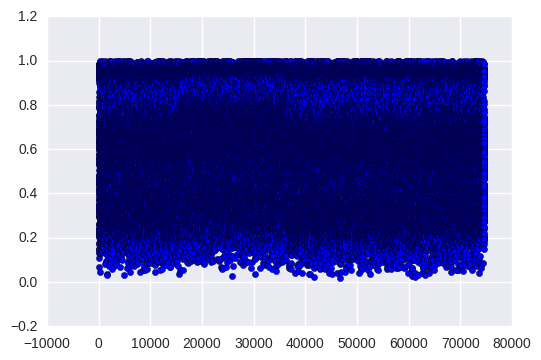

In [94]:
tmp1 = pd.DataFrame(test_blend_x_gbm).loc[:,:2]
tmp1.columns = ['high','medium','low']

plt.scatter(range(74659),tmp1.low)

In [95]:
tmp1.head()

,high,medium,low
0,0.036084,0.539001,0.424915
1,0.001400,0.025558,0.973042
2,0.085998,0.381262,0.532741
3,0.090951,0.519925,0.389124
4,0.226236,0.553447,0.220317


In [96]:
now = datetime.now()
df = pd.read_json(open("../input/test.json", "r"))
sub_name = '../output/sub_LightGBM_' + str(now.strftime("%Y-%m-%d-%H-%M")) + '.csv'

sub = pd.DataFrame()
sub["listing_id"] = df["listing_id"]
# tmp1.columns = ['0','1','2']
for label in ["high", "medium", "low"]:
    sub[label] = tmp1[label]
sub.to_csv(sub_name, index=False)